In [6]:
import sys
import scipy.io.wavfile as wav
import numpy as np
from IPython.display import Audio
import os
import pandas as pd
import torch
from pydub import AudioSegment
import io
import ffmpeg
import librosa
import IPython.display as ipd
import subprocess
import soundfile as sf
import numpy as np
from scipy.io import wavfile
from pydub import AudioSegment
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
path_for_songs = '/home/ics/Task_2_Tanya/SoundsMRSP'
dir_list = os.listdir(path_for_songs)
print(dir_list)
files = {}
for entry in dir_list:
    full_path = os.path.join(path_for_songs, entry)
    if os.path.isdir(full_path):
        files[entry] = os.listdir(full_path)
    else:
        files[entry] = entry

df = pd.DataFrame([(file, genre) for genre, files in files.items() for file in files], columns=['file_name', 'genre'])
df.reset_index(drop=True, inplace=True)
df.index += 1
df

['walking_on_leaf', 'smoothie', 'drum_kit', 'traffic', 'drums']


,file_name,genre
1,walking-on-leafs-forestReverbHall.wav,walking_on_leaf
2,walking-on-leafs-forestOperaHall.wav,walking_on_leaf
3,walking-on-leafs-forest.wav,walking_on_leaf
4,walking-on-leafs-forestSmallOffice.wav,walking_on_leaf
5,smoothie-partyReverbHall.wav,smoothie
6,smoothie-partyOperaHall.wav,smoothie
7,smoothie-party.wav,smoothie
8,smoothie-partySmallOffice.wav,smoothie
9,drum-kit24SmallOffice.wav,drum_kit
10,drum-kit24.wav,drum_kit


In [8]:
def f_SP_dB_torch(maxfreq, nfilts):
    # usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    # computes the spreading function protoype, in the Bark scale.
    # Arguments: maxfreq: half the sampling freqency
    # nfilts: Number of subbands in the Bark domain, for instance 64
    # upper end of our Bark scale:22 Bark at 16 kHz
    maxbark = hz2bark_torch(maxfreq)
    # Number of our Bark scale bands over this range: nfilts=64
    spreadingfunctionBarkdB = torch.zeros(2*nfilts)
    # Spreading function prototype, "nfilts" bands for lower slope
    spreadingfunctionBarkdB[0:nfilts] = torch.linspace(
        -maxbark*27, -8, nfilts)-23.5
    # "nfilts" bands for upper slope:
    spreadingfunctionBarkdB[nfilts:2 *
                            nfilts] = torch.linspace(0, -maxbark*12.0, nfilts)-23.5
    return spreadingfunctionBarkdB


def spreadingfunctionmat_torch(spreadingfunctionBarkdB, alpha, nfilts):
    # Turns the spreading prototype function into a matrix of shifted versions.
    # Convert from dB to "voltage" and include alpha exponent
    # nfilts: Number of subbands in the Bark domain, for instance 64
    spreadingfunctionBarkVoltage = 10.0**(
        spreadingfunctionBarkdB/20.0*alpha)
    # Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix = torch.zeros((nfilts, nfilts))
    for k in range(nfilts):
        spreadingfuncmatrix[k, :] = spreadingfunctionBarkVoltage[(
            nfilts-k):(2*nfilts-k)]
    return spreadingfuncmatrix


def maskingThresholdBark_torch(mXbark, spreadingfuncmatrix, alpha, fs, nfilts):
    # Computes the masking threshold on the Bark scale with non-linear superposition
    # usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    # Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    # spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    # alpha: exponent for non-linear superposition (eg. 0.6),
    # fs: sampling freq., nfilts: number of Bark subbands
    # nfilts: Number of subbands in the Bark domain, for instance 64
    # Returns: mTbark: the resulting Masking Threshold on the Bark scale

    # Compute the non-linear superposition:
    mTbark = torch.matmul(mXbark**alpha, spreadingfuncmatrix**alpha)
    # apply the inverse exponent to the result:
    mTbark = mTbark**(1.0/alpha)
    # Threshold in quiet:
    maxfreq = fs/2.0
    maxbark = hz2bark_torch(maxfreq)
    step_bark = maxbark/(nfilts-1)
    barks = torch.arange(0, nfilts)*step_bark
    # convert the bark subband frequencies to Hz:
    f = bark2hz_torch(barks)+1e-6
    # Threshold of quiet in the Bark subbands in dB:
    LTQ = torch.clip((3.64*(f/1000.)**-0.8 - 6.5*torch.exp(-0.6*(f/1000.-3.3)**2.)
                      + 1e-3*((f/1000.)**4.)), -20, 120)
    # Maximum of spreading functions and hearing threshold in quiet:
    a = mTbark
    b = 10.0**((LTQ-60)/20)
    mTbark = torch.max(a, b)
    return mTbark


def hz2bark_torch(f):
    """ Usage: Bark=hz2bark(f)
          f    : (ndarray)    Array containing frequencies in Hz.
      Returns  :
          Brk  : (ndarray)    Array containing Bark scaled values.
      """
    if not torch.is_tensor(f):
        f = torch.tensor(f)

    Brk = 6. * torch.arcsinh(f/600.)
    return Brk


def bark2hz_torch(Brk):
    """ Usage:
      Hz=bark2hs(Brk)
      Args     :
          Brk  : (ndarray)    Array containing Bark scaled values.
      Returns  :
          Fhz  : (ndarray)    Array containing frequencies in Hz.
      """
    if not torch.is_tensor(Brk):
        Brk = torch.tensor(Brk)
    Fhz = 600. * torch.sinh(Brk/6.)
    return Fhz


def mapping2barkmat_torch(fs, nfilts, nfft):
    # Constructing mapping matrix W which has 1's for each Bark subband, and 0's else
    # usage: W=mapping2barkmat(fs, nfilts,nfft)
    # arguments: fs: sampling frequency
    # nfilts: number of subbands in Bark domain
    # nfft: number of subbands in fft
    # upper end of our Bark scale:22 Bark at 16 kHz
    maxbark = hz2bark_torch(fs/2)
    nfreqs = nfft/2
    step_bark = maxbark/(nfilts-1)
    binbark = hz2bark_torch(
        torch.linspace(0, (nfft/2), (nfft//2)+1)*fs/nfft)
    W = torch.zeros((nfilts, nfft))
    for i in range(nfilts):
        W[i, 0:int(nfft/2)+1] = (torch.round(binbark/step_bark) == i)
    return W


def mapping2bark_torch(mX, W, nfft):
    # Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
    # arguments: mX: magnitude spectrum from fft
    # W: mapping matrix from function mapping2barkmat
    # nfft: : number of subbands in fft
    # returns: mXbark, magnitude mapped to the Bark scale
    nfreqs = int(nfft/2)
    # Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (torch.matmul(
        torch.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
    return mXbark


def mappingfrombarkmat_torch(W, nfft):
    # Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    # usuage: W_inv=mappingfrombarkmat(Wnfft)
    # argument: W: mapping matrix from function mapping2barkmat
    # nfft: : number of subbands in fft
    nfreqs = int(nfft/2)
    W_inv = torch.matmul(torch.diag(
        (1.0/(torch.sum(W, 1)+1e-6))**0.5), W[:, 0:nfreqs + 1]).T
    return W_inv

# -------------------


def mappingfrombark_torch(mTbark, W_inv, nfft):
    # usage: mT=mappingfrombark(mTbark,W_inv,nfft)
    # Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    # arguments:
    # mTbark: masking threshold in the Bark domain
    # W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    # nfft: : number of subbands in fft
    # returns: mT, masking threshold in the linear scale
    nfreqs = int(nfft/2)
    mT = torch.matmul(mTbark, W_inv[:, :nfreqs].T.float())
    return mT


In [9]:
def psyacthresh_torch(ys, fs):
    # input: ys: 2d array of sound STFT (from a mono signal, shape N+1,M)
    # fs: sampling frequency in samples per second
    # returns: mT, the masking threshold in N+1 subbands for the M blocks (shape N+1,M)

    maxfreq = fs/2
    alpha = 0.8  # Exponent for non-linear superposition of spreading functions
    nfilts = 64  # number of subbands in the bark domain
    # M=len(snd)//nfft
    M = ys.shape[1]
    # N=nfft//2
    N = ys.shape[0]-1
    nfft = 2*N

    W = mapping2barkmat_torch(fs, nfilts, nfft)
    W_inv = mappingfrombarkmat_torch(W, nfft)
    spreadingfunctionBarkdB = f_SP_dB_torch(maxfreq, nfilts)
    # maxbark=hz2bark(maxfreq)
    # bark=np.linspace(0,maxbark,nfilts)
    spreadingfuncmatrix = spreadingfunctionmat_torch(
        spreadingfunctionBarkdB, alpha, nfilts)
    # Computing the masking threshold in each block of nfft samples:
    mT = torch.zeros((N+1, M))
    for m in range(M):  # M: number of blocks
        # mX=np.abs(np.fft.fft(snd[m*nfft+np.arange(2048)],norm='ortho'))[0:1025]
        mX = torch.abs(ys[:, m])
        mXbark = mapping2bark_torch(mX, W, nfft)
        # Compute the masking threshold in the Bark domain:
        mTbark = maskingThresholdBark_torch(
            mXbark, spreadingfuncmatrix, alpha, fs, nfilts)
        # Massking threshold in the original frequency domain
        mT[:, m] = mappingfrombark_torch(mTbark, W_inv, nfft)

    return mT  # the masking threshold in N+1 subbands for the M blocks


def percloss(orig, modified, fs):
    # computes the perceptually weighted distance between the original (orig) and modified audio signals,
    # with sampling rate fs. The psycho-acoustic threshold is computed from orig, hence it is not commutative.
    # returns: ploss, the perceptual loss value, the mean squarred difference of the two spectra, normalized to the masking threshold of the orig.
    # Gerald Schuller, September 2023

    nfft = 2048  # number of fft subbands
    N = nfft//2

    # print("orig.shape=", orig.shape)
    
    # origsys.shape= freq.bin, channel, block
    if len(orig.shape) == 2:  # multichannel
        chan = orig.shape[1]
        for c in range(chan):
            origys = torch.stft(orig[:,c], n_fft=2*N, hop_length=2 *
                        N//2, return_complex=True, normalized=True, window=torch.hann_window(2*N))
            if c == 0:  # initialize masking threshold tensor mT
                mT0 = psyacthresh_torch(origys[:, :], fs)
                rows, cols = mT0.shape
                mT = torch.zeros((rows, chan, cols))
                mT[:, 0, :] = mT0
            else:
                mT[:, c, :] = psyacthresh_torch(origys[:, :], fs)
    else:
        chan = 1
        origys = torch.stft(orig, n_fft=2*N, hop_length=2 *
                        N//2, return_complex=True, normalized=True, window=torch.hann_window(2*N))
        mT = psyacthresh_torch(origys, fs)
    """
    plt.plot(20*np.log10(np.abs(origys[:,0,400])+1e-6))
    plt.plot(20*np.log10(mT[:,0,400]+1e-6))
    plt.legend(('Original spectrum','Masking threshold'))
    plt.title("Spectrum over bins")
    """
    # print("origys.shape=",origys.shape, "mT.shape=",mT.shape)

    modifiedys = torch.stft(
        modified, n_fft=2*N, hop_length=2*N//2, return_complex=True, normalized=True, window=torch.hann_window(2*N))

    # normalized diff. spectrum:
    normdiffspec = torch.abs((origys-modifiedys)/mT)
    # Plot difference spectrum, normalized to masking threshold:
    """
    plt.plot(20*np.log10(normdiffspec[:,0,400])+1e-6)
    plt.title("normalized diff. spectrum")
    plt.show()
    """
    ploss = torch.mean(normdiffspec**2)
    return ploss

In [10]:
def plot_audio_comparison(snd, snd_quant, snd_aac, sample_rate):
    plt.figure(figsize=(15, 5))

    snd_float = snd.astype(np.float32) / np.max(np.abs(snd))
    snd_quant_float = snd_quant.astype(np.float32) / np.max(np.abs(snd_quant))
    snd_aac_float = snd_aac.astype(np.float32) / np.max(np.abs(snd_aac))

    plt.subplot(1, 3, 1)
    librosa.display.waveshow(snd_float, sr=sample_rate)
    plt.title('Original Audio')
    plt.subplot(1, 3, 2)
    librosa.display.waveshow(snd_quant_float, sr=sample_rate)
    plt.title('Quantized Audio')
    plt.subplot(1, 3, 3)
    librosa.display.waveshow(snd_aac_float, sr=sample_rate)
    plt.title('AAC Encoded Audio')
    plt.tight_layout()
    plt.show()

def simulate_aac(signal, preservation_factor=0.9):
    noise = np.random.normal(0, 0.01, len(signal))
    return signal * preservation_factor + noise

def quantize(signal, levels):
    return np.round(signal * (levels-1)) / (levels-1)

walking-on-leafs-forestReverbHall.wav walking_on_leaf
310525


/tmp/ipykernel_299139/2927701226.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, original_audio = wavfile.read(file_path)


tensor(20.3631) tensor(2.1240) tensor(0.1043)


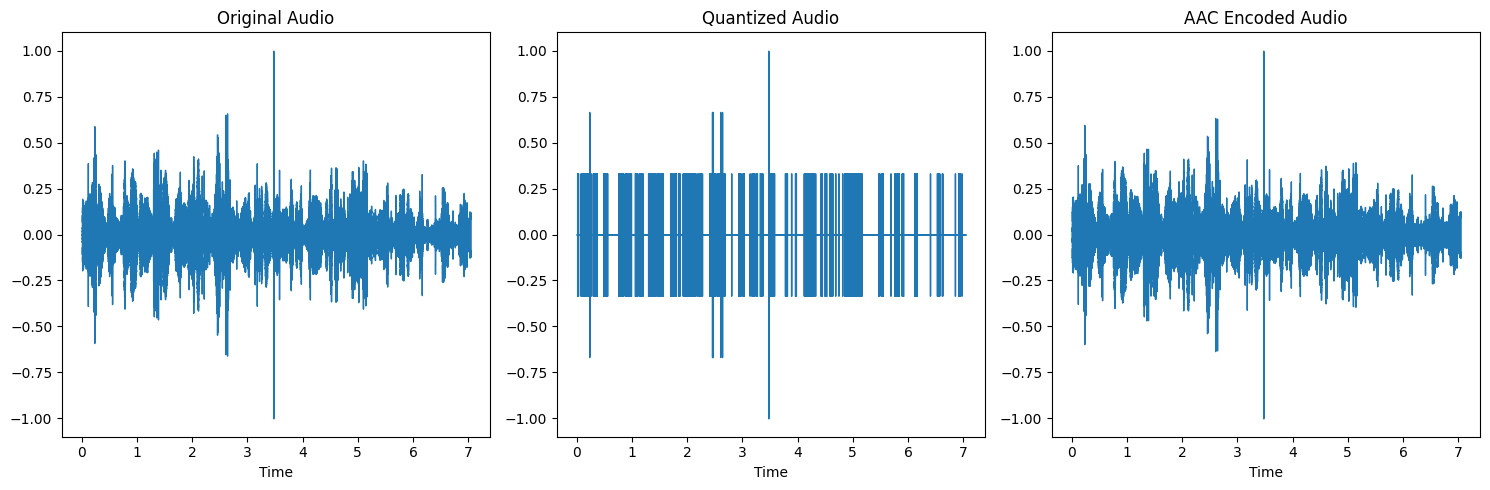

walking-on-leafs-forestOperaHall.wav walking_on_leaf
310525


/tmp/ipykernel_299139/2927701226.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, original_audio = wavfile.read(file_path)


tensor(23.5916) tensor(2.2626) tensor(0.0959)


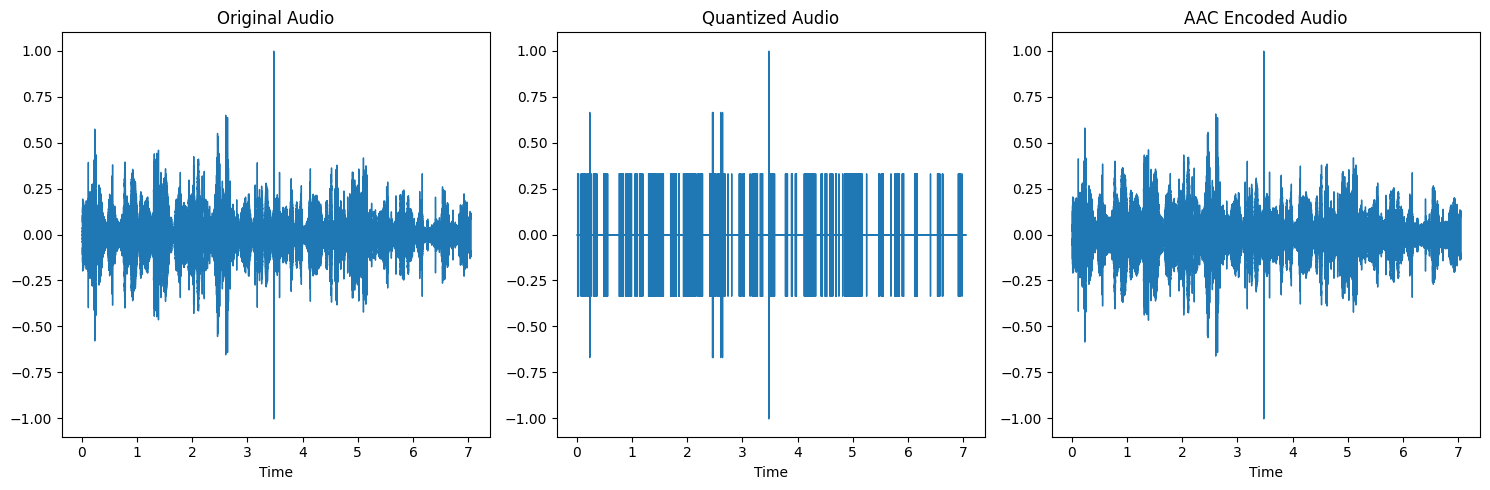

walking-on-leafs-forest.wav walking_on_leaf
310525
tensor(23.0518) tensor(2.5199) tensor(0.1093)


/tmp/ipykernel_299139/2927701226.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, original_audio = wavfile.read(file_path)


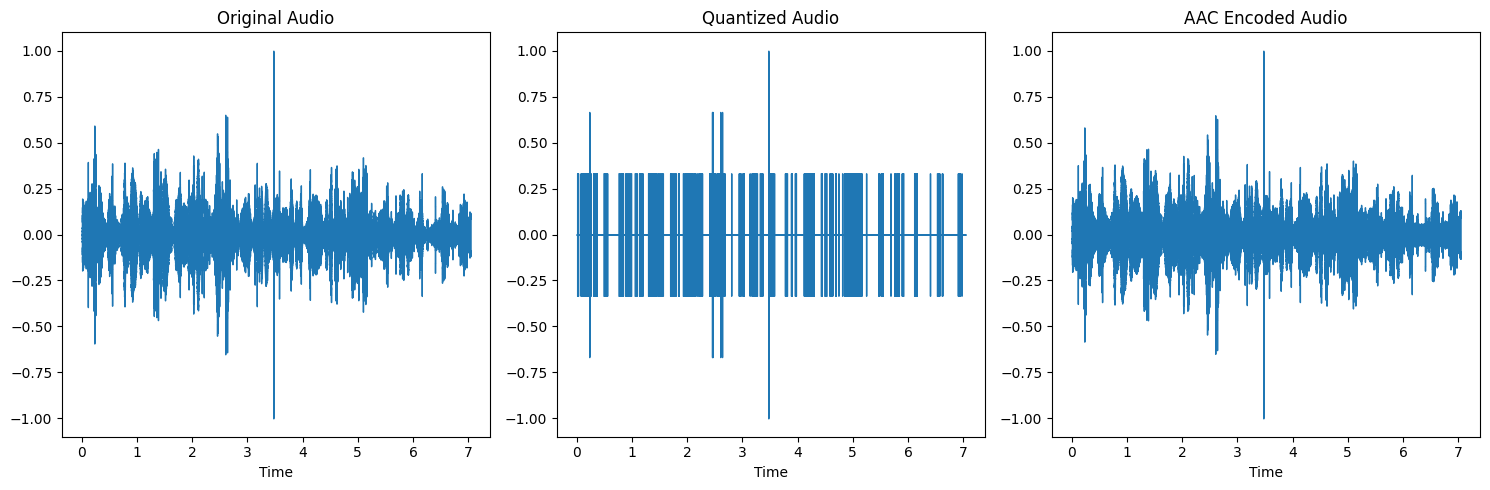

walking-on-leafs-forestSmallOffice.wav walking_on_leaf
310525
tensor(22.9792) tensor(2.5295) tensor(0.1101)


/tmp/ipykernel_299139/2927701226.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, original_audio = wavfile.read(file_path)


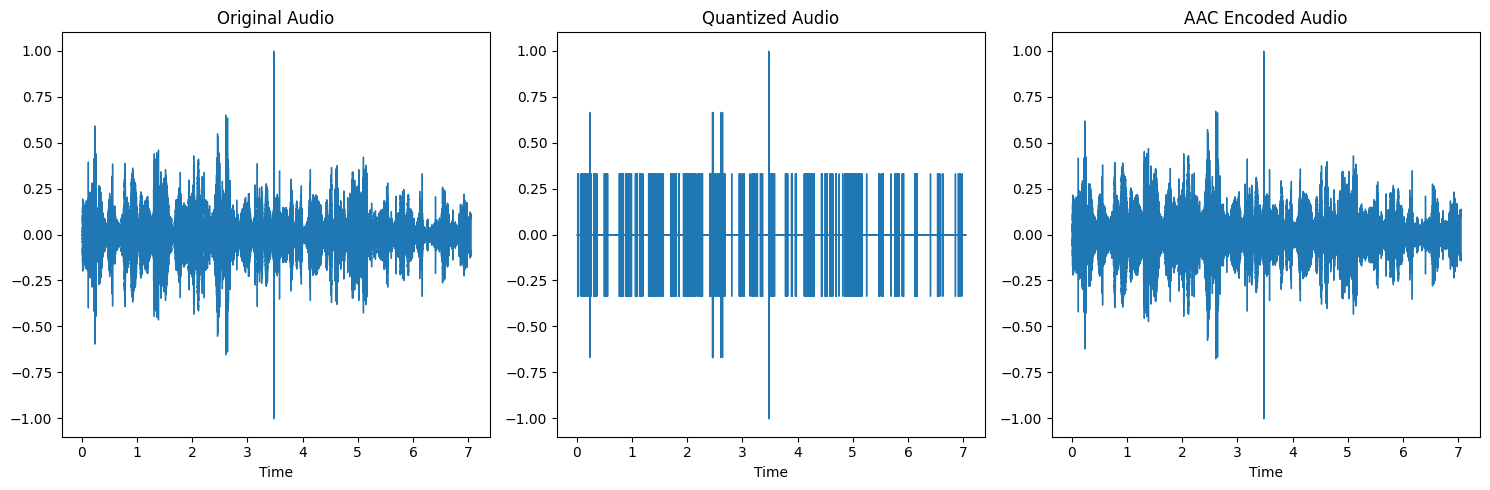

smoothie-partyReverbHall.wav smoothie
328639
tensor(27.0177) tensor(9.7832) tensor(0.3621)


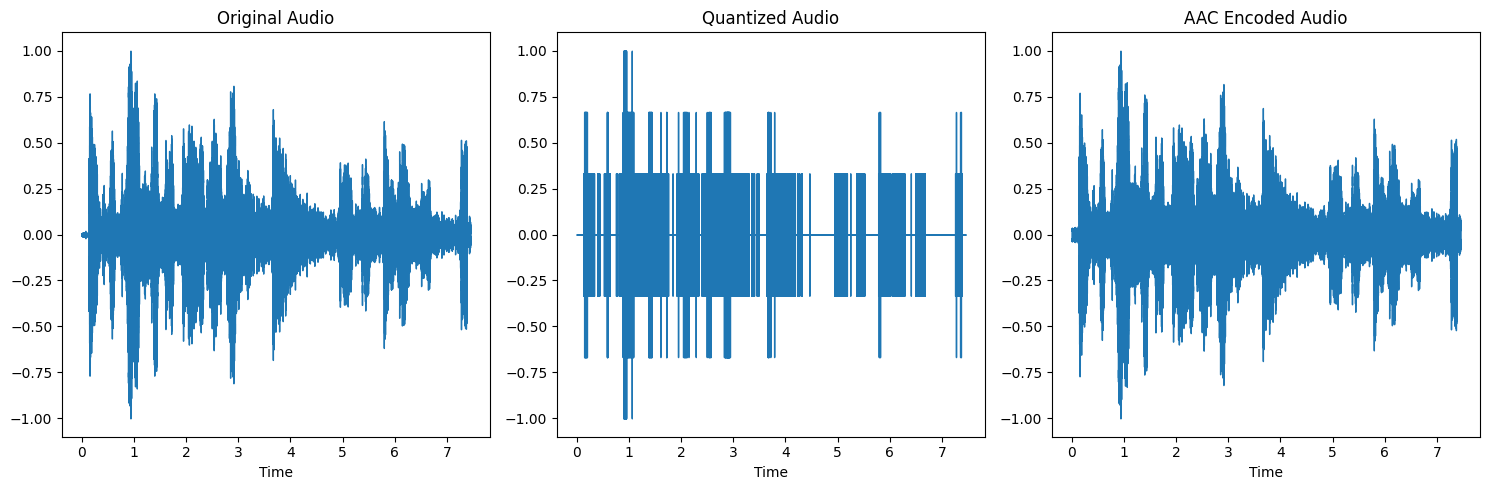

smoothie-partyOperaHall.wav smoothie
328639
tensor(14.7413) tensor(11.1460) tensor(0.7561)


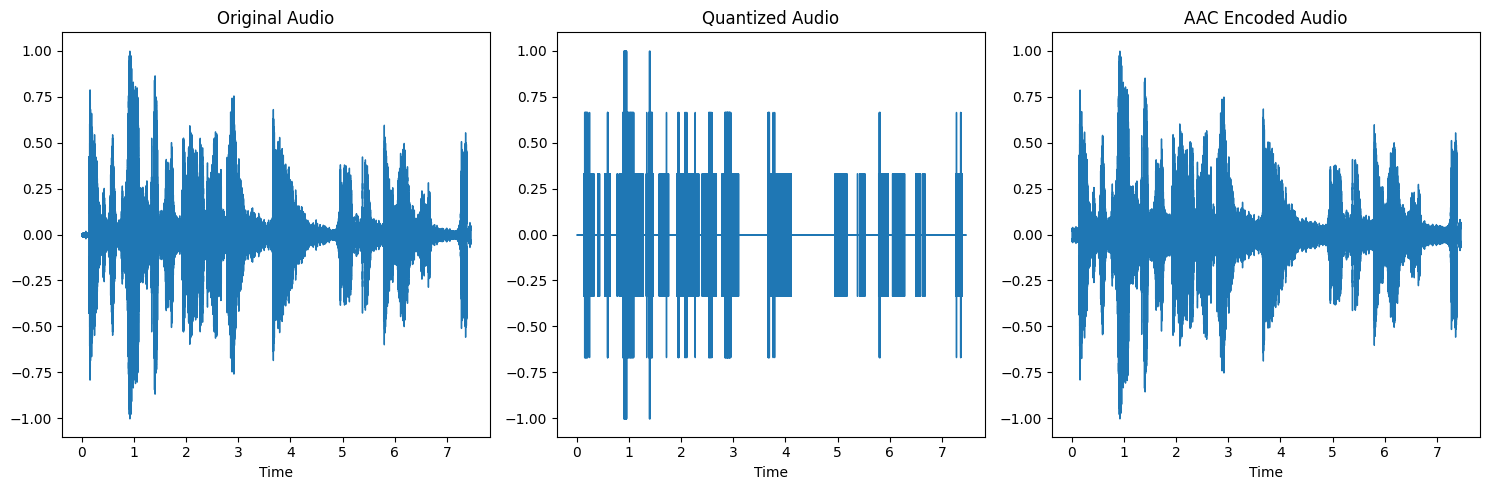

smoothie-party.wav smoothie
328639
tensor(14.0707) tensor(17.2950) tensor(1.2292)


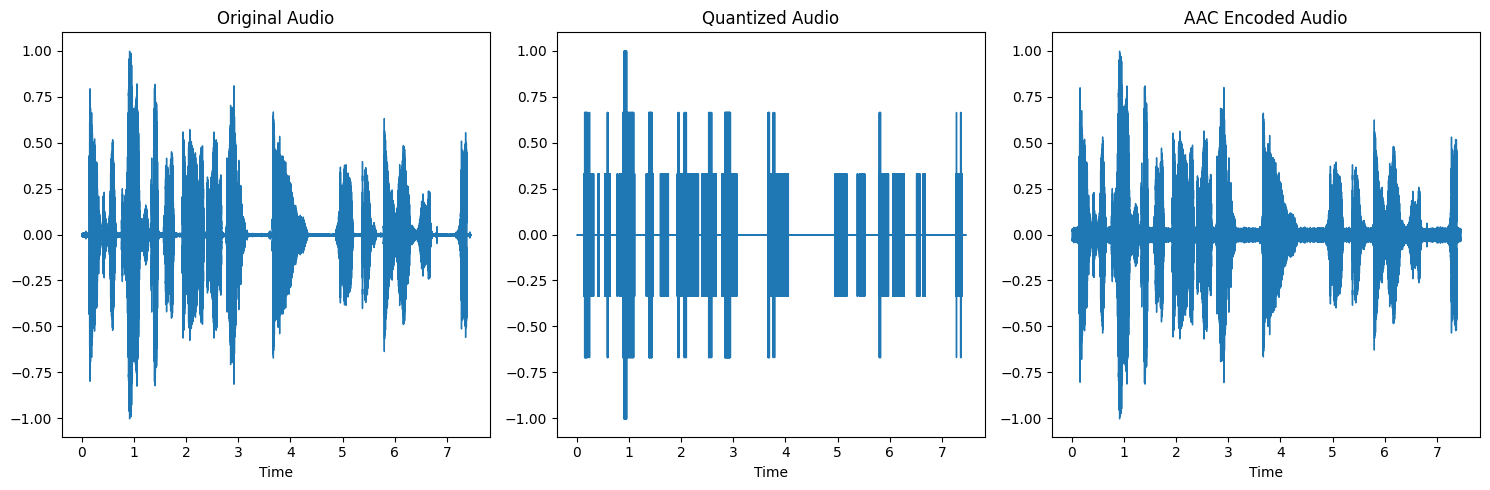

smoothie-partySmallOffice.wav smoothie
328639
tensor(14.0217) tensor(16.7623) tensor(1.1955)


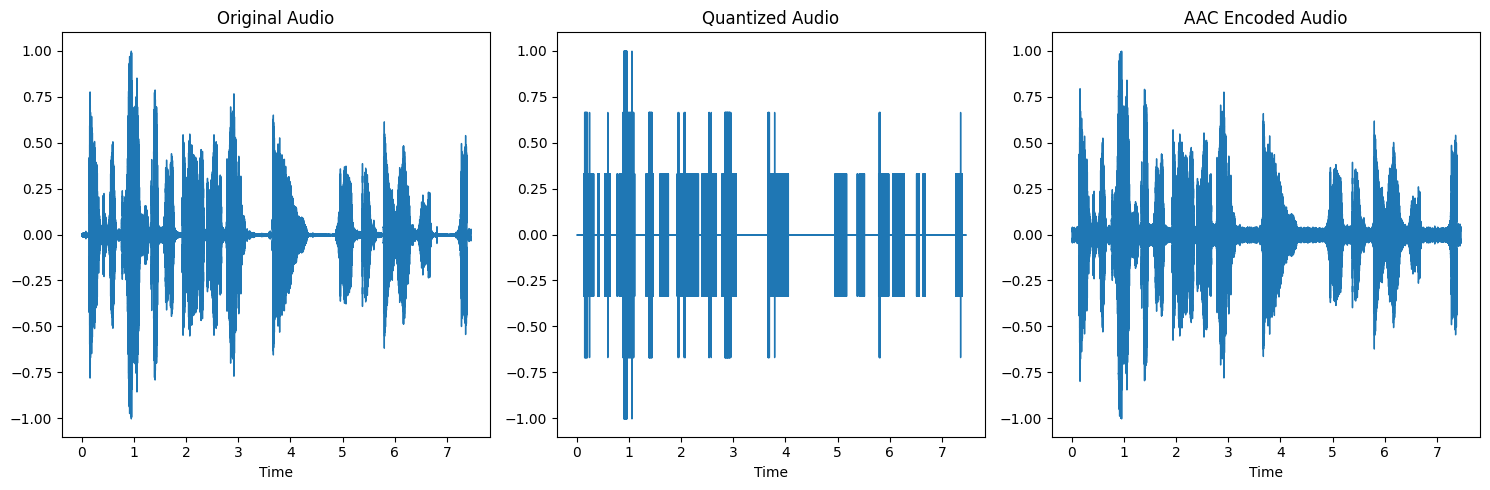

drum-kit24SmallOffice.wav drum_kit
429566
tensor(72.3363) tensor(41.1076) tensor(0.5683)


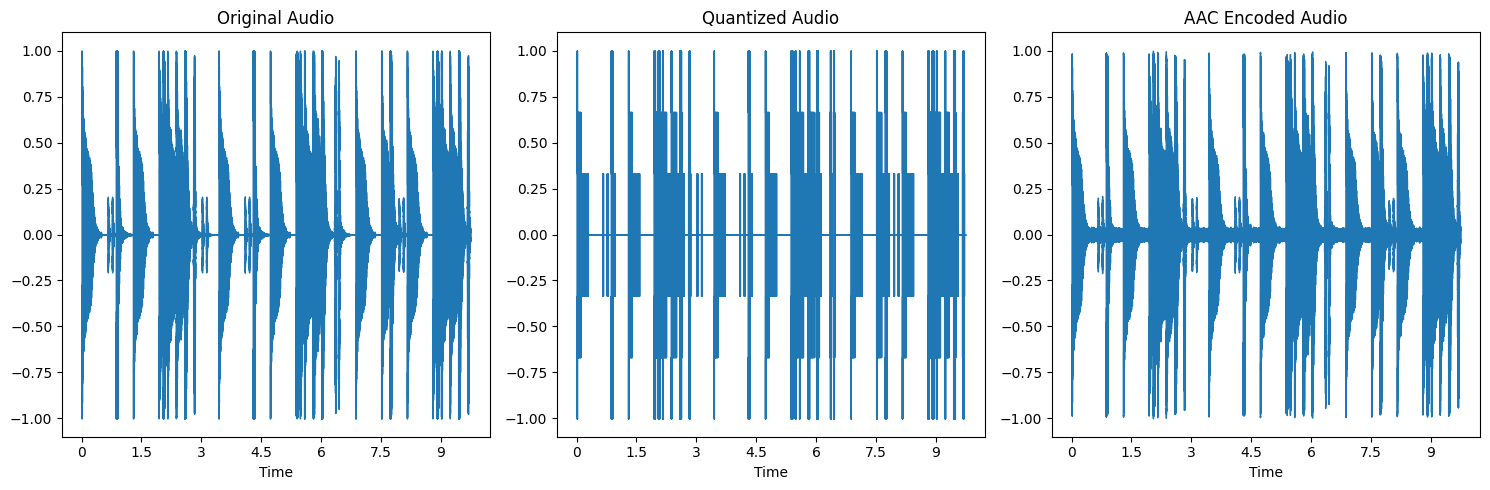

drum-kit24.wav drum_kit
429566
tensor(85.5042) tensor(54.4329) tensor(0.6366)


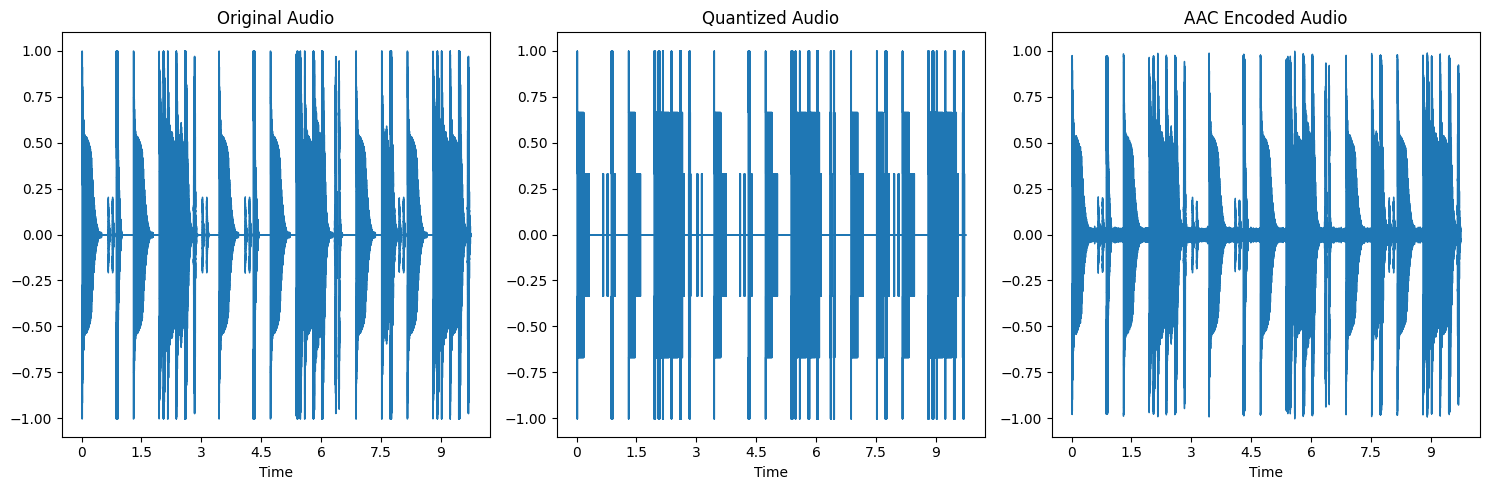

drum-kit24OperaHall.wav drum_kit
429566
tensor(113.5220) tensor(21.5949) tensor(0.1902)


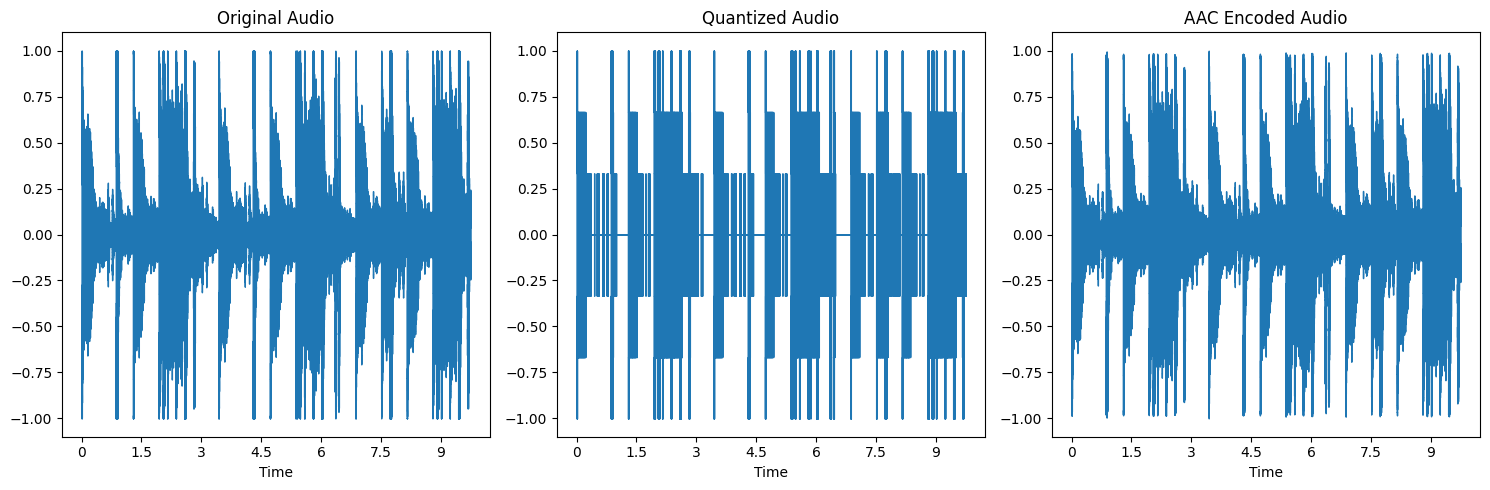

drum-kit24ReverbHall.wav drum_kit
429566
tensor(193.7837) tensor(16.9442) tensor(0.0874)


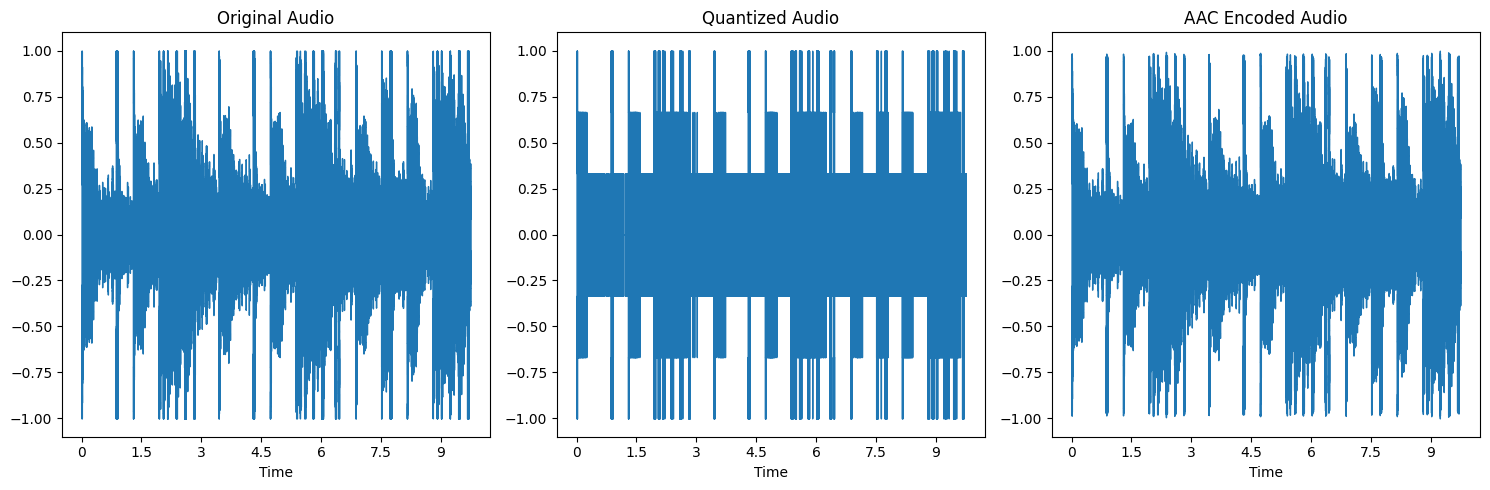

traffic_reverb.wav traffic
2880000
tensor(128.6803) tensor(5.1134) tensor(0.0397)


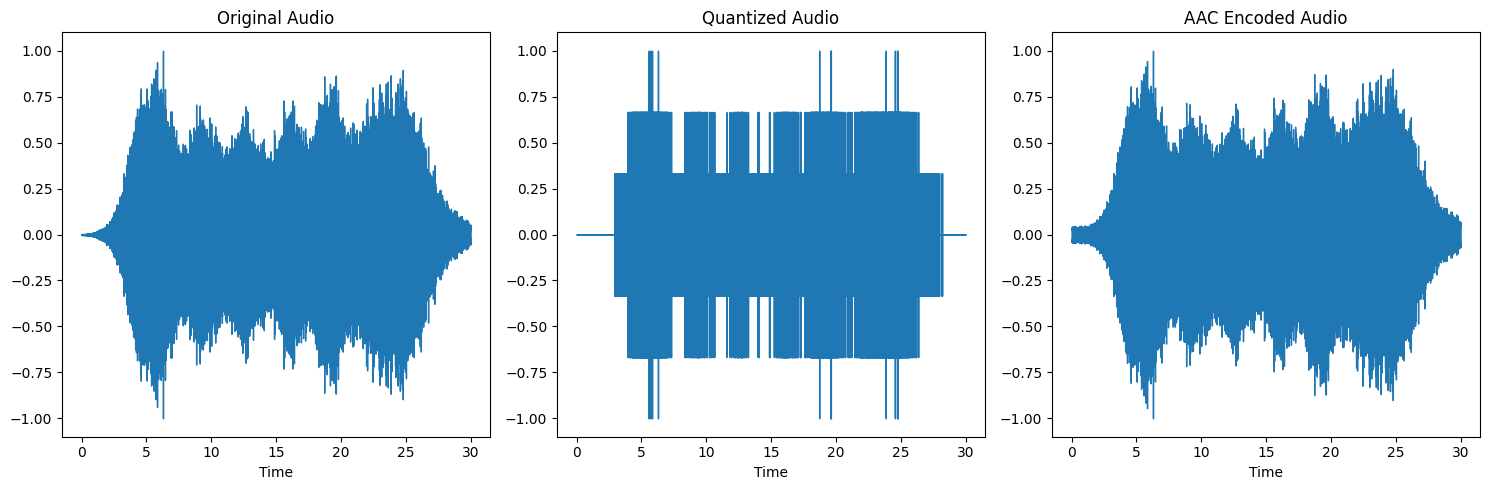

traffic_opera.wav traffic
2880000
tensor(161.3424) tensor(5.6641) tensor(0.0351)


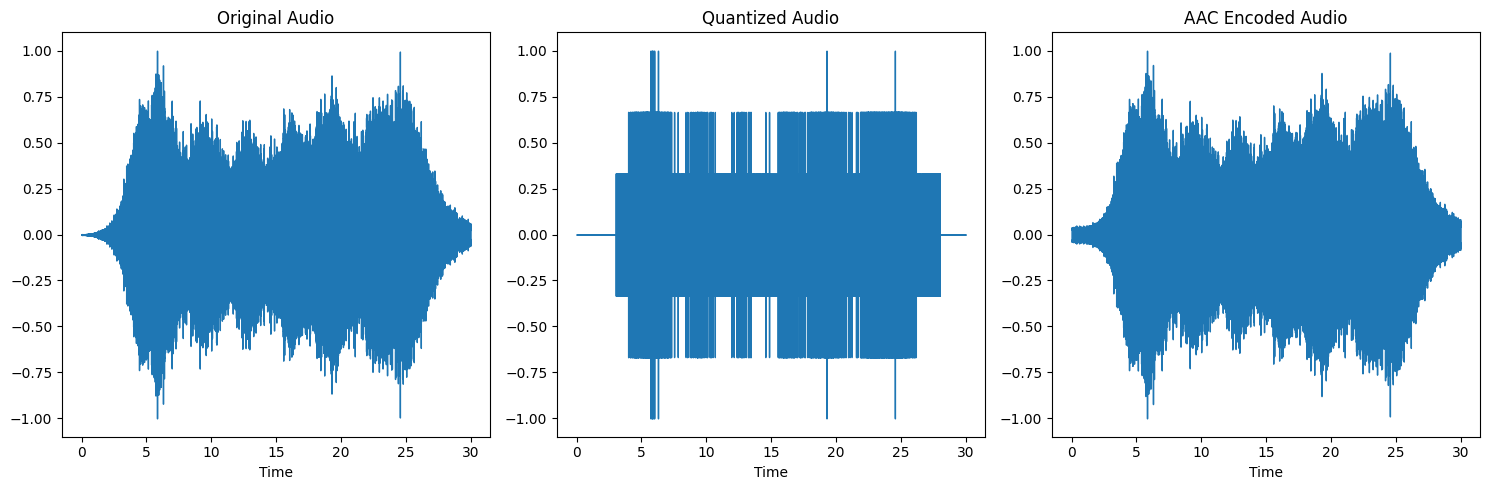

traffic_sound.wav traffic
2880000


/tmp/ipykernel_299139/2927701226.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, original_audio = wavfile.read(file_path)


tensor(2.7757) tensor(2.8214) tensor(1.0165)


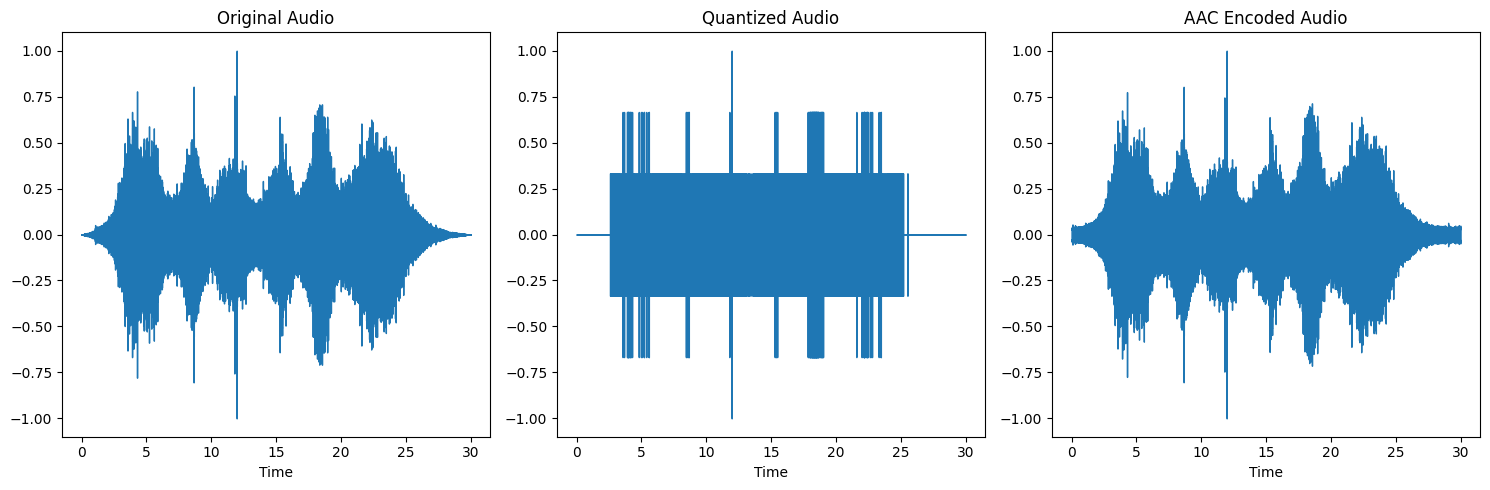

traffic_small.wav traffic
1323000
tensor(86.6381) tensor(4.3064) tensor(0.0497)


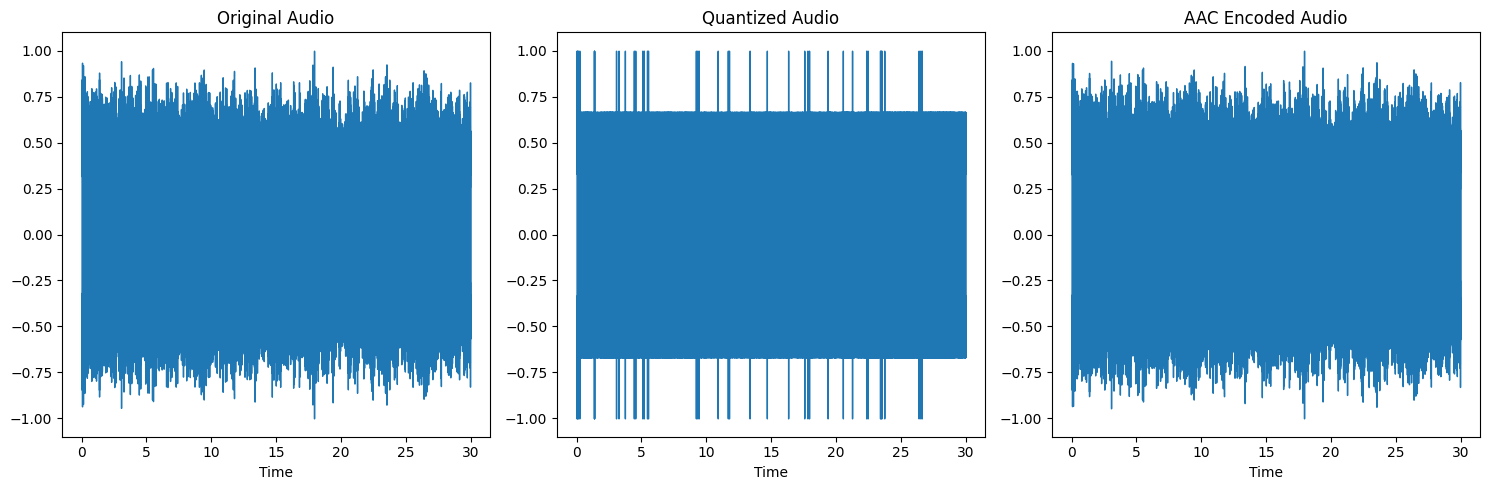

drums_raw.wav drums
1323000


/tmp/ipykernel_299139/2927701226.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, original_audio = wavfile.read(file_path)


tensor(89.8224) tensor(4.9360) tensor(0.0550)


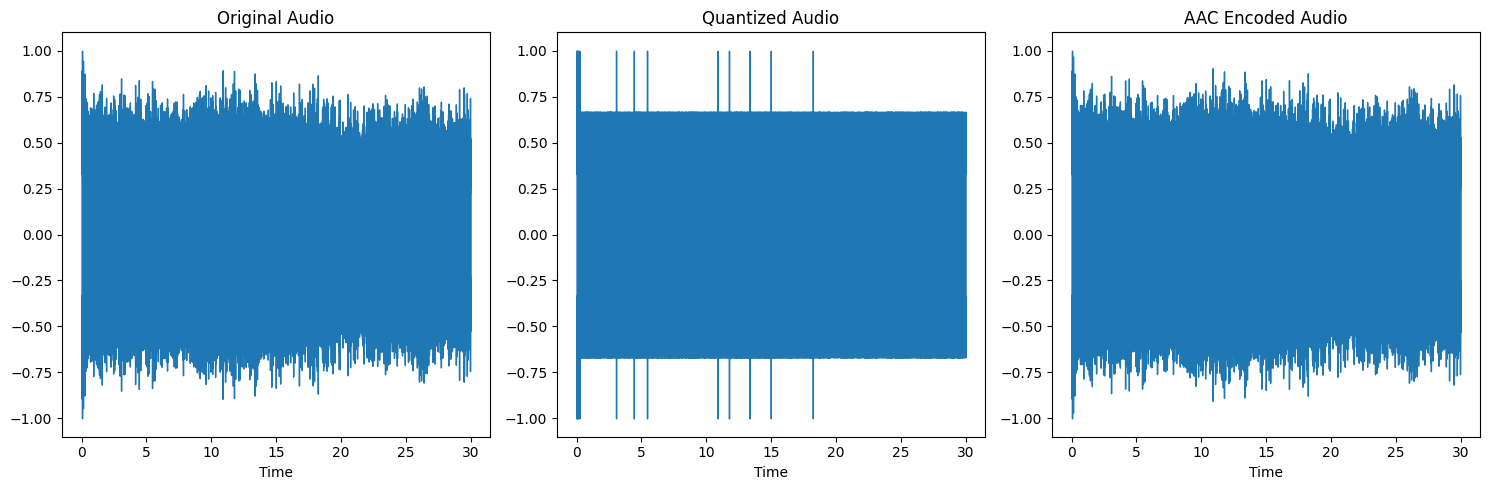

drums_small.wav drums
1323000
tensor(1177.6611) tensor(32.9990) tensor(0.0280)


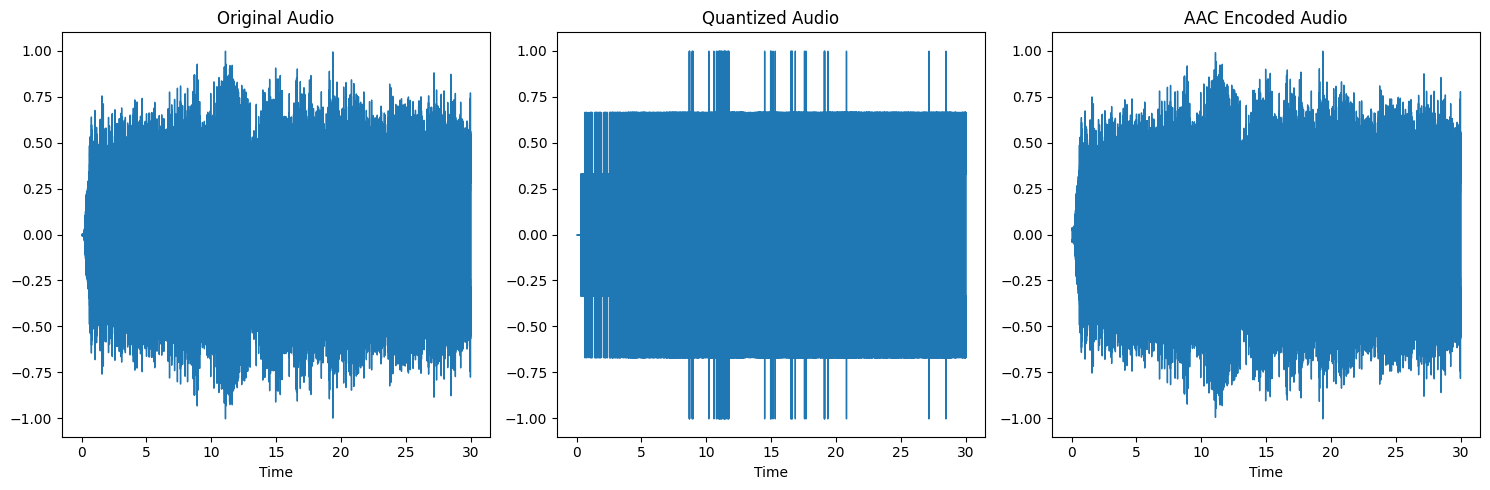

drums_opera.wav drums
1323000
tensor(92.9838) tensor(5.0188) tensor(0.0540)


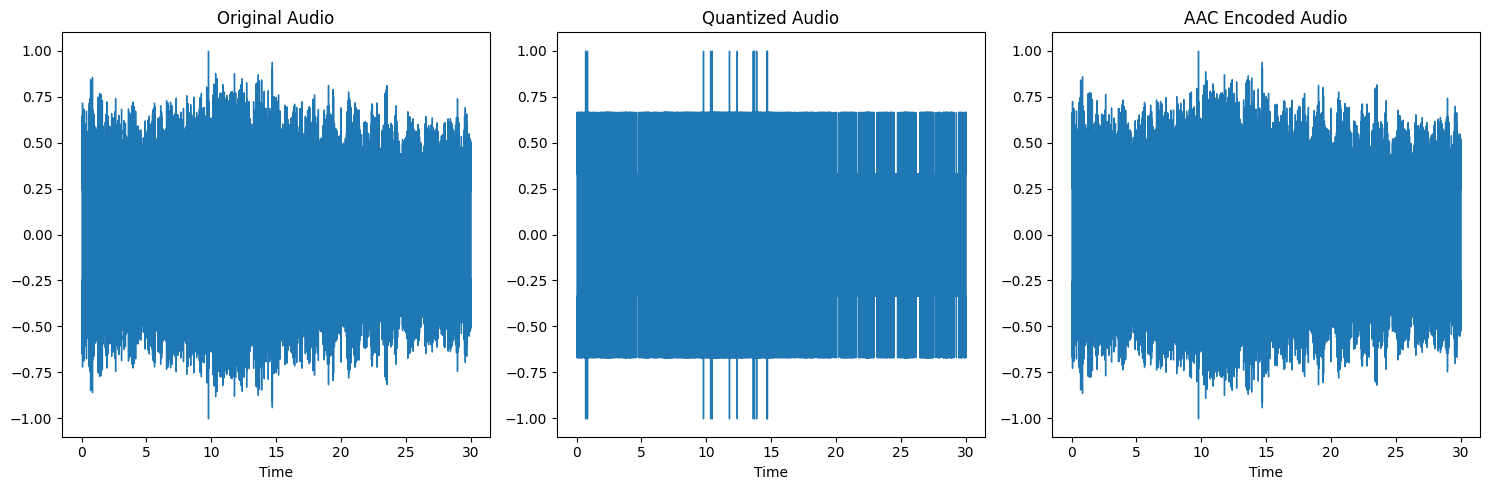

drums_reverb.wav drums
1323000
tensor(87.3709) tensor(4.2382) tensor(0.0485)


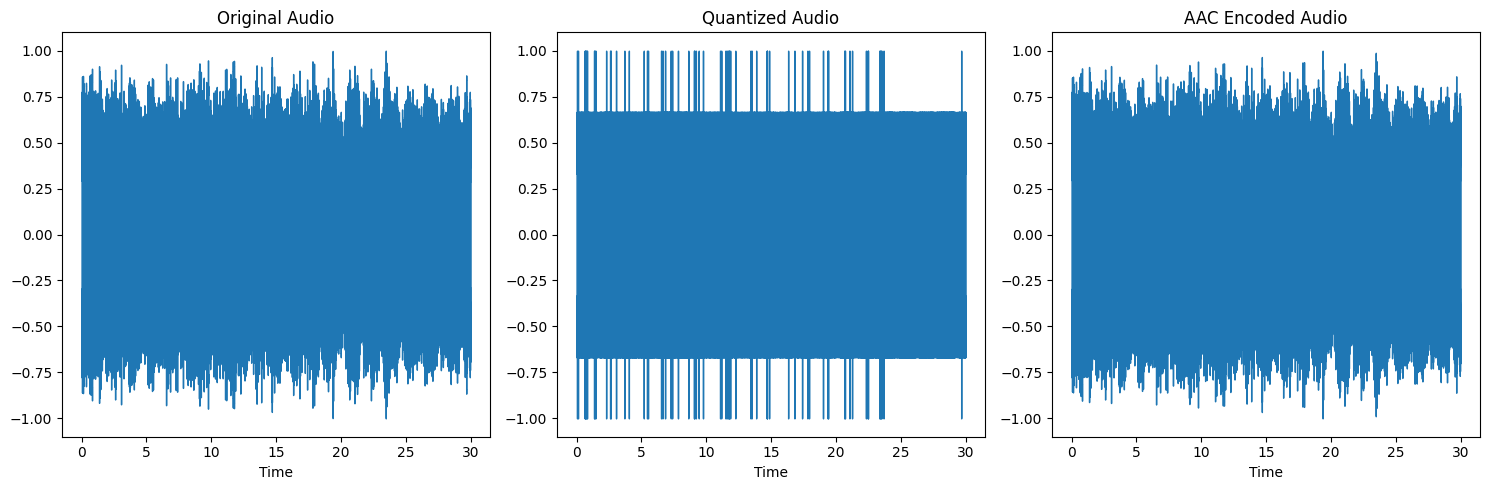

In [11]:
for i in range(1, len(df)+1):
    file_name = df.loc[i, 'file_name']
    genre = df.loc[i, 'genre']
    print(file_name, genre)
    file_path = os.path.join(path_for_songs, genre, file_name)
    sample_rate, original_audio = wavfile.read(file_path)
    if len(original_audio.shape) > 1:
        original_audio = np.mean(original_audio, axis=1)
    original_audio = original_audio.astype(float) / np.max(np.abs(original_audio))
    time = np.linspace(0, len(original_audio) / sample_rate, len(original_audio))
    print(len(time))
    quantized_audio = quantize(original_audio, 4)
    aac_audio = simulate_aac(original_audio)

    quantized_file_name = file_name.replace('.wav', '_quantized.wav')
    aac_file_name = file_name.replace('.wav', '_aac.wav')
    wavfile.write(quantized_file_name, sample_rate, quantized_audio)
    wavfile.write(aac_file_name, sample_rate, aac_audio)

    if len(original_audio.shape) == 2 or len(quantized_audio.shape) == 2 or len(aac_audio.shape) == 2:
        original_audio = original_audio[:, 0]
        quantized_audio = quantized_audio[:, 0]
    else:
        original_audio = original_audio
        quantized_audio = quantized_audio
    ploss_quant = percloss(torch.from_numpy(original_audio).float(), torch.from_numpy(quantized_audio).float(), sample_rate)
    ploss_aac = percloss(torch.from_numpy(original_audio).float(), torch.from_numpy(aac_audio).float(), sample_rate)
    print(ploss_quant, ploss_aac, ploss_aac/ploss_quant)
    plot_audio_comparison(original_audio, quantized_audio, aac_audio, sample_rate)
    df.loc[i, 'ploss_quant'] = ploss_quant.item()
    df.loc[i, 'ploss_aac'] = ploss_aac.item()

In [12]:
df['ploss_aac_to_quant_ratio'] = df['ploss_aac'] / df['ploss_quant']
df.to_csv('results.csv', index=False)
df

,file_name,genre,ploss_quant,ploss_aac,ploss_aac_to_quant_ratio
1,walking-on-leafs-forestReverbHall.wav,walking_on_leaf,20.363134,2.123978,0.104305
2,walking-on-leafs-forestOperaHall.wav,walking_on_leaf,23.591612,2.262627,0.095908
3,walking-on-leafs-forest.wav,walking_on_leaf,23.051805,2.519948,0.109317
4,walking-on-leafs-forestSmallOffice.wav,walking_on_leaf,22.979189,2.529531,0.110079
5,smoothie-partyReverbHall.wav,smoothie,27.017710,9.783183,0.362103
6,smoothie-partyOperaHall.wav,smoothie,14.741269,11.145970,0.756107
7,smoothie-party.wav,smoothie,14.070694,17.295040,1.229153
8,smoothie-partySmallOffice.wav,smoothie,14.021708,16.762257,1.195450
9,drum-kit24SmallOffice.wav,drum_kit,72.336273,41.107563,0.568284
10,drum-kit24.wav,drum_kit,85.504158,54.432873,0.636611
